## Simulation of 60-degree roto-translation of <110> dumbbells in dilute Fe-Cr alloy.
In this notebook, we use the onsager calculator we created in part 1 to compute transport coefficients for the dumbbell-mediated mechanism for dilute Cr in Fe.

The data of the energies are taken from the database given along with the paper by Messina et. al. - https://doi.org/10.1016/j.actamat.2020.03.038

We need to identify the solute-dumbbell complex states with the appropriate labels give in this paper, as well as the various dumbbell jump types. We then assign appropriate state formation and dumbbell migration energies, as per the data given in the above-mentioned database.

We then compare the Green's function results for the drag and partial diffusion coefficient ratios with the results from SCMF calculations taken also from the above-mentioned database.

In [1]:
import numpy as np

from scipy.constants import physical_constants
kB = physical_constants['Boltzmann constant in eV/K'][0]
from matplotlib import pyplot as plt

import pickle
import time

In [2]:
%%time
# Let's load the pickle file we just saved containing the onsager calculator
with open("FeX_60RT.pkl","rb") as fl:
    onsagercalculator = pickle.load(fl)

CPU times: user 12min 20s, sys: 24.4 s, total: 12min 44s
Wall time: 12min 21s


### Now, we'll look at the complex states in our thermodynamic shell
We take the first state from each symmetry group of states, and print out its info in groups
of three lines.

For each state, the number printed out in the first line is the index assgined to the
symmetry group (called the "star") the state belongs to.

The second line gives the pure dumbbell orientation vector in cartesian coordinates (Recall that the length of the orientation vector is taken to be the atomic diameter of iron).

The third line prints the position of the dumbbell with respect to the solute location
in cartesian coordinates. Recall that the lattice parameter of BCC Fe is 0.2831 nm, as per Messina et al.'s paper.

Note that the first complex state (with index 0 in the first line) is an origin state (pure dumbbell on top of solute) and is unphysical.

From index 1 onwards, we'll then have to manually match our complex states with the labels in Messina et. al. (1nnA, 1nnB etc). No interaction will be assumed when a corresponding state label is not found in Messina et. al.'s database. For example, a particualr 4nn state found below was not considered in the SCMF calculations.
The first 13 such symmetry group starting from index 1 are going to contain all the states we need to consider.

In [3]:
count = 0
for star in onsagercalculator.thermo.stars[:onsagercalculator.thermo.mixedstartindex]:
    print(count)
    db = star[0].db
    print(np.round(onsagercalculator.pdbcontainer.iorlist[db.iorind][1], decimals=4)+0)
    print(np.dot(onsagercalculator.crys.lattice, db.R))
    print()
    count += 1

0
[ 0.1782 -0.1782  0.    ]
[0. 0. 0.]

1
[ 0.1782  0.     -0.1782]
[0.14155 0.14155 0.14155]

2
[ 0.1782  0.     -0.1782]
[ 0.14155  0.14155 -0.14155]

3
[ 0.1782 -0.1782  0.    ]
[-0.2831  0.      0.    ]

4
[ 0.1782 -0.1782  0.    ]
[ 0.      0.     -0.2831]

5
[ 0.1782 -0.1782  0.    ]
[-0.2831  0.      0.2831]

6
[ 0.1782 -0.1782  0.    ]
[-0.2831  0.2831  0.    ]

7
[ 0.     -0.1782 -0.1782]
[ 0.      0.2831 -0.2831]

8
[ 0.1782  0.     -0.1782]
[ 0.42465 -0.14155  0.14155]

9
[ 0.1782 -0.1782  0.    ]
[-0.42465  0.14155 -0.14155]

10
[ 0.      0.1782 -0.1782]
[-0.42465 -0.14155 -0.14155]

11
[ 0.1782 -0.1782  0.    ]
[ 0.14155 -0.14155 -0.42465]

12
[-0.1782 -0.1782  0.    ]
[0.2831 0.2831 0.2831]

13
[-0.1782 -0.1782  0.    ]
[ 0.2831 -0.2831  0.2831]

14
[-0.1782 -0.1782  0.    ]
[-0.42465  0.14155 -0.42465]

15
[-0.1782 -0.1782  0.    ]
[-0.42465 -0.14155 -0.42465]

16
[ 0.1782 -0.1782  0.    ]
[-0.42465  0.42465 -0.14155]

17
[ 0.     -0.1782 -0.1782]
[ 0.14155  0.42465 -0.4

In [4]:
# Next, we assign labels to the states we have just identified.
# No interaction will be assumed when a corresponding state label is not found in Messina et. al.'s database
# For example, the one 4nn state was not considered in the SCMF calculations.

name_to_themo_star = {"1nnA":1, "1nnB":2, "2nnA":4, "2nnB":3, "3nnA": 7, "3nnB":5, "3nnC":6,
       "4nnA":10,"4nnB":11,"4nnC":9, "5nnA":13, "5nnB":12}

In [5]:
# We then sort out all the jumps with the appropriate nomenclatures
jmpdict = {"1nnA_2nnA":[], "1nnA_2nnB":[], "1nnA_3nnB":[], "1nnA_3nnC":[], "1nnB_2nnB":[], "1nnB_3nnB":[],
          "1nnB_5nnB":[], "2nnA_4nnC":[], "2nnB_4nnB":[], "2nnB_4nnC":[]}


for jlistind, jlist in enumerate(onsagercalculator.jnet1):
    jmp = jlist[0]
    state1 = jmp.state1
    state2 = jmp.state2
    
    # Get the symmetry groups ("stars") of the states in the kinetic shell of states
    star1 = onsagercalculator.kinetic.complexIndexdict[state1][1]
    star2 = onsagercalculator.kinetic.complexIndexdict[state2][1]
    
    # Check if these states are in the thermodynamic shell of states
    if star1 in onsagercalculator.thermo2kin and star2 in onsagercalculator.thermo2kin:
        thermo_star1 = onsagercalculator.thermo.complexIndexdict[state1][1]
        thermo_star2 = onsagercalculator.thermo.complexIndexdict[state2][1]
        name1 = ""
        name2 = ""
        #Now see which categories the states belong to
        star1found = False
        count1 = 0
        star2found = False
        count2 = 0
        for (key, value) in name_to_themo_star.items():
            if thermo_star1==value:
                star1found = True
                count1 += 1
                name1 = key
            if thermo_star2==value:
                star2found = True
                count2 += 1
                name2 = key
        # just to ensure we don't have any multiple counting.
        if count1>1:
            print(thermo_star1)
        if count2>1:
            print(thermo_star2)
        # Now concatenate names
        jname = name1+"_"+name2
        jnamerev = name2+"_"+name1
        try:
            jmpdict[jname].append(jlistind)
        except:
            try:
                # maybe the jump we have is the reverse of what we stored as the label in the dictionary?
                jmpdict[jnamerev].append(jlistind)
            except:    
                continue

# check to see we have found all the jumps
jmpdict         

{'1nnA_2nnA': [6],
 '1nnA_2nnB': [1],
 '1nnA_3nnB': [5],
 '1nnA_3nnC': [3],
 '1nnB_2nnB': [4],
 '1nnB_3nnB': [2],
 '1nnB_5nnB': [7],
 '2nnA_4nnC': [8],
 '2nnB_4nnB': [9],
 '2nnB_4nnC': [10]}

In [6]:
E_f_pdb = 4.0799084 # formation energy of pure dumbbell - from database
# Now, we assign energies to the complex states in the thermo shell
# name to supercell energy
name_to_en = {"1nnA":-2081.86385487, "1nnB":-2081.96714335, 
              "2nnA":-2081.84673179, "2nnB":-2081.84805032, 
              "3nnA":-2081.86785633, "3nnB":-2081.89911432,
              "3nnC":-2081.89517078, "4nnA":-2081.89240119,
              "4nnB":-2081.88260599, "4nnC":-2081.90014080,
              "5nnA":-2081.90574167, "5nnB":-2081.89623144}

In [7]:
E_sup_pdb = -2080.58061654
E_sup_solute = -2077.70333299
E_bulk = -2076.35510458 # E_bulk is the same as E_ref
name_to_Ef = {}
for (key, E_IB) in name_to_en.items():
    # get the binding energy first
    Eb = -E_IB + E_sup_pdb + E_sup_solute - E_bulk
    # Next, get the formation energy (relative to solute formation energy)
    name_to_Ef[key] = E_f_pdb - Eb

# Let's look at the formation energies to see if they are okay
name_to_Ef

{'1nnA': 4.144898479999916,
 '1nnB': 4.041610000000197,
 '2nnA': 4.1620215600000625,
 '2nnB': 4.1607030300001275,
 '3nnA': 4.140897019999989,
 '3nnB': 4.1096390299999035,
 '3nnC': 4.113582569999813,
 '4nnA': 4.116352160000111,
 '4nnB': 4.12614736000021,
 '4nnC': 4.108612550000067,
 '5nnA': 4.103011679999759,
 '5nnB': 4.112521909999919}

In [8]:
# The complex energies are set. Now, we set the mixed dumbbell energies
E_b_mdb = 2081.97387181 + E_sup_pdb + E_sup_solute - E_bulk
E_f_mdb = E_f_pdb - E_b_mdb

# Check the mixed dumbbell binding energy
print(E_f_mdb - E_f_pdb)

-0.04502686000023459


In [9]:
Jname_2_TS_en = {"1nnA_2nnA":-2081.53754083, "1nnA_2nnB":-2081.45300295, "1nnA_3nnB":-2081.54309435,
                 "1nnA_3nnC":-2081.51203629, "1nnB_2nnB":-2081.59390973, "1nnB_3nnB":-2081.58124941,
                 "1nnB_5nnB":-2081.56664001, "2nnA_4nnC":-2081.53814922, "2nnB_4nnB":-2081.53362146,
                 "2nnB_4nnC":-2081.53385038}

In [10]:
# Now, we have to find the TS energies.
Jname_2_ef_ts = {}
for (key, E_IB) in Jname_2_TS_en.items():
    Eb = -E_IB + E_sup_pdb + E_sup_solute - E_bulk
    # Next, get the formation energy (relative to solute formation energy)
    Jname_2_ef_ts[key] = E_f_pdb - Eb

In [11]:
Jname_2_ef_ts

{'1nnA_2nnA': 4.471212519999859,
 '1nnA_2nnB': 4.5557503999998294,
 '1nnA_3nnB': 4.465658999999937,
 '1nnA_3nnC': 4.496717059999788,
 '1nnB_2nnB': 4.4148436199998065,
 '1nnB_3nnB': 4.427503939999929,
 '1nnB_5nnB': 4.442113340000083,
 '2nnA_4nnC': 4.470604130000061,
 '2nnB_4nnB': 4.475131889999807,
 '2nnB_4nnC': 4.474902970000108}

In [13]:
Jname_2_mig = {}
for (key, TS_en) in Jname_2_ef_ts.items():
    initstar = key[:4]
    Jname_2_mig[key] = TS_en - name_to_Ef[initstar]

In [14]:
# Check that correct energies have been assigned to the jumps by matching with Messina et. al.'s paper
# Table 2
Jname_2_mig

{'1nnA_2nnA': 0.3263140399999429,
 '1nnA_2nnB': 0.41085191999991366,
 '1nnA_3nnB': 0.32076052000002164,
 '1nnA_3nnC': 0.35181857999987187,
 '1nnB_2nnB': 0.3732336199996098,
 '1nnB_3nnB': 0.38589393999973254,
 '1nnB_5nnB': 0.4005033399998865,
 '2nnA_4nnC': 0.30858256999999867,
 '2nnB_4nnB': 0.31442885999967984,
 '2nnB_4nnC': 0.3141999399999804}

In [15]:
E_IB_43, E_IB_2 = -2081.60898764, -2081.73238117
Eb_43, Eb_2 = -E_IB_43 + E_sup_pdb + E_sup_solute - E_bulk, -E_IB_2 + E_sup_pdb + E_sup_solute - E_bulk 
# Next, get the formation energy (relative to solute formation energy)
ef_ts_43 = E_f_pdb - Eb_43
ef_ts_2 = E_f_pdb - Eb_2
print(ef_ts_2-E_f_mdb, ef_ts_43 - E_f_mdb, ef_ts_43 - name_to_Ef["1nnB"])

0.2414906400003929 0.36488417000009576 0.3581557099996644


## Cr calculations

In [16]:
# Jump rates and energy barriers set. Now, let's set the calculations up.
vu0=4.4447 # attempt frequencies of pure dumbbell jumps. 
vu2=4.5551 # attempt frequencies of mixed dumbbell jumps.
Dconv=1e-2 # to have units in cm^2/s from nm^2*THz

# entropic pre-factors and formation energies for pure dumbbells.
predb0, enedb0 = np.ones(1), np.array([E_f_pdb])

# Here on, pre-factors are going to 1.0
# We'll measure every formation energy relative to the solute formation energy.
# so we set solute formation energy to zero, and (as per data) pre-factor to 1.
preS, eneS = np.ones(1), np.array([0.0])

# Next, interaction or the excess energies and pre-factors for solutes and dumbbells.
preSdb, eneSdb = np.ones(onsagercalculator.thermo.mixedstartindex), \
                 np.zeros(onsagercalculator.thermo.mixedstartindex)
# Now, we go over the necessary stars and assign interaction energies
for (key, index) in name_to_themo_star.items():
    eneSdb[index] = name_to_Ef[key] - E_f_pdb

predb2, enedb2 = np.ones(1), np.array([E_f_mdb])

# Transition state energies - For omega0, omega2 and omega43, the first type is the Johnson jump,
# and the second one is the Rigid jump.

# Omega0 TS eneriges
preT0, eneT0 = Dconv*vu0*np.ones(1), np.array([E_f_pdb + 0.33759025])

# Omega2 TS energies
Nj2 = len(onsagercalculator.jnet2)
preT2, eneT2 = Dconv*vu2*np.ones(Nj2), np.array([ef_ts_2])

# Omega43 TS energies
preT43, eneT43 = Dconv*vu0*np.ones(1), np.array([ef_ts_43])

# Omega1 TS energies
preT1 = Dconv*vu0*np.ones(len(onsagercalculator.jnet1))
eneT1 = np.array([eneT0[i] for i in onsagercalculator.om1types])
# Now, we go over the jumps that are provided and make the necessary changes
for (key, index) in jmpdict.items():
    eneT1[index] = Jname_2_ef_ts[key]
    
# set origin state jumps to zeros - the code handles this anyway
eneT1[0] = 0.0

In [17]:
# Then we calculate the transport coefficients
from tqdm import tqdm

# In the scmf database, the temperatures are between 200K to 4000K (inclusive) in steps of 10
temp = np.arange(200, 4001, 10)

diff_aa_Cr = np.zeros(len(temp))
diff_ab_Cr = np.zeros(len(temp))
diff_bb = np.zeros(len(temp))
diff_bb_non_loc = np.zeros(len(temp))

start = time.time()
for i in tqdm(range(len(temp)), position=0, leave=True, ncols=65):
    T = temp[i]
    kT = kB*T
    
    # get the free energies multiplied by kBT
    bFdb0, bFdb2, bFS, bFSdb, bFT0, bFT1, bFT2, bFT3, bFT4 = \
        onsagercalculator.preene2betafree(kT, predb0, enedb0, preS, eneS, preSdb, eneSdb, predb2, enedb2,
                                               preT0, eneT0, preT2, eneT2, preT1, eneT1, preT43, eneT43)

    # get the transport coefficients - "a" is the solute, "b" is the solvent (Fe).
    # The uncorrelated (L_uc) and correlated (L_c) parts will be summed to get the total
    # transport coefficients.
    L0bb, (L_uc_aa,L_c_aa), (L_uc_bb,L_c_bb), (L_uc_ab,L_c_ab)=\
    onsagercalculator.L_ij(bFdb0, bFT0, bFdb2, bFT2, bFS, bFSdb, bFT1, bFT3, bFT4)
    
    L_aa = L_uc_aa + L_c_aa
    L_bb = L_uc_bb + L_c_bb
    L_ab = L_uc_ab + L_c_ab
    
    diff_aa_Cr[i] = L_aa[0][0]
    diff_ab_Cr[i] = L_ab[0][0]
    diff_bb[i] = L_bb[0][0]
    diff_bb_non_loc[i] = L0bb[0][0]
        
print(time.time() - start)

100%|██████████████████████████| 381/381 [40:29<00:00,  6.38s/it]

2429.6851060390472


In [18]:
# Now let's do the infinite temeperature limit
kT = np.inf
bFdb0, bFdb2, bFS, bFSdb, bFT0, bFT1, bFT2, bFT3, bFT4 = \
    onsagercalculator.preene2betafree(kT, predb0, enedb0, preS, eneS, preSdb, eneSdb, predb2, enedb2,
                                           preT0, eneT0, preT2, eneT2, preT1, eneT1, preT43, eneT43)

# get the transport coefficients
L0bb, (L_uc_aa,L_c_aa), (L_uc_bb,L_c_bb), (L_uc_ab,L_c_ab)=\
onsagercalculator.L_ij(bFdb0, bFT0, bFdb2, bFT2, bFS, bFSdb, bFT1, bFT3, bFT4)

L_aa = L_uc_aa + L_c_aa
L_bb = L_uc_bb + L_c_bb
L_ab = L_uc_ab + L_c_ab

# Get the drag ratio
drag_inf = L_ab[0][0]/L_aa[0][0]

In [19]:
# Load the SCMF drag and PDC ratios extracted from Messina et. al.'s results to compare

# First, the drag ratios
Drag_dat_SCMF = []
with open("../SCMF_Messina_et_al/DragRatio_Cr.dat","r") as fl:
    for line in fl:
        arr = line.split()
        Drag_dat_SCMF.append(float(arr[0]))
Drag_dat_SCMF = np.array(Drag_dat_SCMF)

# Then, the PDC ratios
PDC_dat_SCMF = []
with open("../SCMF_Messina_et_al/PDC_ratio_Cr.dat","r") as fl:
    for line in fl:
        arr = line.split()
        PDC_dat_SCMF.append(float(arr[1])) # the temperatures are the first values in the PDC files
PDC_dat_SCMF = np.array(PDC_dat_SCMF)

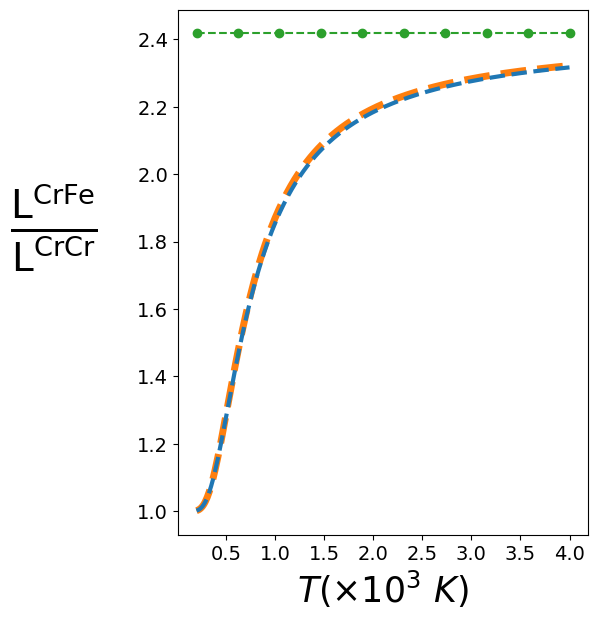

In [20]:
# Plot and compare with Messina et. al. - we do just the drag ratios here

colorGF = "tab:blue"
colorMessina = "tab:orange"

colorInf = "tab:green"

infAll = "tab:green"
inf60 = infAll

lwMessina = 5
lwGF = 3

tempScale = temp/1000.
tempSpace = np.linspace(tempScale[0], tempScale[-1], 10, endpoint=True)

plt.figure(figsize=(18,15))
plt.subplot(2,3,1)
plt.plot(tempScale, Drag_dat_SCMF, ls="--", color=colorMessina, lw=lwMessina)
plt.plot(tempScale, diff_ab_Cr/diff_aa_Cr, ls="--", color=colorGF, lw=lwGF)
plt.plot(tempSpace, np.ones_like(tempSpace)*drag_inf, ls='--', color=inf60, marker="o")
plt.xlabel(r'$T (\times 10^3 \ K)$', fontsize = 25)
plt.ylabel(r'$\mathrm{\frac{L^{CrFe}}{L^{CrCr}}}$', rotation=0, labelpad = 60, fontsize = 40)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [21]:
# Now save the data for plotting later on
import h5py
with h5py.File("Cr_data.h5","w") as fl:
    fl.create_dataset("diff_aa", data=diff_aa_Cr)
    fl.create_dataset("diff_ab", data=diff_ab_Cr)
    fl.create_dataset("diff_bb_nl", data=diff_bb_non_loc)
    fl.create_dataset("diff_bb", data=diff_bb)
    fl.create_dataset("drag_inf", data=np.array([drag_inf]))
    fl.create_dataset("Temp", data=np.array(temp))